# RSCD Road Surface Classification

This notebook trains an image classifier to predict road-surface classes using the RSCD dataset.
It uses the train split (folders per class) and parses labels from filenames for validation/test.

Notes:
- The full dataset is large; use the `MAX_*_SAMPLES` knobs for quick experiments.
- Pretrained weights require an existing local cache or internet access; set `USE_PRETRAINED` accordingly.


In [24]:
from pathlib import Path
import random
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt

DATA_ROOT = Path("data") / "RSCD dataset-1million"
TRAIN_DIR = DATA_ROOT / "train"
VAL_DIR = DATA_ROOT / "vali_20k"
TEST_DIR = DATA_ROOT / "test_50k"

SEED = 42
BATCH_SIZE = 64
IMAGE_SIZE = 224
NUM_WORKERS = 0
EPOCHS = 3
LR = 3e-4
WEIGHT_DECAY = 1e-4
USE_PRETRAINED = False

MAX_TRAIN_SAMPLES = None
MAX_VAL_SAMPLES = None
MAX_TEST_SAMPLES = None

CLASS_NAMES = sorted([p.name for p in TRAIN_DIR.iterdir() if p.is_dir()]) if TRAIN_DIR.exists() else []

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(SEED)
device = torch.device("mps") if torch.backends.mps.is_available() else (
    torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
)
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
device


device(type='cuda')

In [25]:
assert TRAIN_DIR.exists(), f"Missing train directory: {TRAIN_DIR}"
assert VAL_DIR.exists(), f"Missing val directory: {VAL_DIR}"
assert TEST_DIR.exists(), f"Missing test directory: {TEST_DIR}"

def normalize_label(label: str):
    if "concrete" in label:
        return None
    return label.replace("_severe", "").replace("_slight", "").replace("_smooth", "")

class_names = []
for name in CLASS_NAMES:
    merged = normalize_label(name)
    if merged is not None and merged not in class_names:
        class_names.append(merged)

num_classes = len(class_names)
(len(CLASS_NAMES), num_classes, class_names)


(27,
 12,
 ['dry_asphalt',
  'dry_gravel',
  'dry_mud',
  'fresh_snow',
  'ice',
  'melted_snow',
  'water_asphalt',
  'water_gravel',
  'water_mud',
  'wet_asphalt',
  'wet_gravel',
  'wet_mud'])

In [26]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

eval_tfms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

base_train_ds = datasets.ImageFolder(TRAIN_DIR, transform=train_tfms)
orig_idx_to_class = {v: k for k, v in base_train_ds.class_to_idx.items()}
class_to_idx = {name: i for i, name in enumerate(class_names)}
idx_to_class = {v: k for k, v in class_to_idx.items()}

class MergedImageFolder(Dataset):
    def __init__(self, base_ds, idx_to_orig_class, class_to_idx):
        self.base_ds = base_ds
        self.indices = []
        self.targets = []
        for sample_idx, (_, orig_target) in enumerate(base_ds.samples):
            orig_label = idx_to_orig_class[orig_target]
            merged_label = normalize_label(orig_label)
            if merged_label is None:
                continue
            self.indices.append(sample_idx)
            self.targets.append(class_to_idx[merged_label])

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        sample_idx = self.indices[idx]
        img, _ = self.base_ds[sample_idx]
        return img, self.targets[idx]

train_ds = MergedImageFolder(base_train_ds, orig_idx_to_class, class_to_idx)

def parse_label_from_filename(path: Path) -> str:
    stem = path.stem
    if "-" not in stem:
        return stem
    _, label = stem.split("-", 1)
    return label.replace("-", "_")

class RSCDFlatDataset(Dataset):
    def __init__(self, root_dir: Path, transform=None, class_to_idx=None):
        self.root_dir = root_dir
        self.transform = transform
        self.class_to_idx = class_to_idx or {}
        all_samples = sorted([p for p in root_dir.iterdir() if p.is_file()])
        self.samples = [
            p for p in all_samples
            if normalize_label(parse_label_from_filename(p)) in self.class_to_idx
        ]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path = self.samples[idx]
        label_name = normalize_label(parse_label_from_filename(path))
        label = self.class_to_idx[label_name]
        img = datasets.folder.default_loader(path)
        if self.transform:
            img = self.transform(img)
        return img, label

val_ds = RSCDFlatDataset(VAL_DIR, transform=eval_tfms, class_to_idx=class_to_idx)
test_ds = RSCDFlatDataset(TEST_DIR, transform=eval_tfms, class_to_idx=class_to_idx)

len(train_ds), len(val_ds), len(test_ds), num_classes


(703279, 13620, 34550, 12)

In [27]:
def maybe_subset(ds, max_samples, seed=42):
    if max_samples is None or max_samples >= len(ds):
        return ds
    rng = np.random.default_rng(seed)
    indices = rng.choice(len(ds), size=max_samples, replace=False)
    return Subset(ds, indices)

def get_targets(dataset):
    if isinstance(dataset, Subset):
        return np.array(dataset.dataset.targets)[dataset.indices]
    return np.array(dataset.targets)

train_ds_sub = maybe_subset(train_ds, MAX_TRAIN_SAMPLES, SEED)
val_ds_sub = maybe_subset(val_ds, MAX_VAL_SAMPLES, SEED)
test_ds_sub = maybe_subset(test_ds, MAX_TEST_SAMPLES, SEED)

train_targets = get_targets(train_ds_sub)
class_counts = np.bincount(train_targets, minlength=num_classes)
class_counts = np.maximum(class_counts, 1)
sample_weights = (1.0 / class_counts)[train_targets]
train_sampler = WeightedRandomSampler(
    weights=torch.tensor(sample_weights, dtype=torch.double),
    num_samples=len(sample_weights),
    replacement=True,
)

loader_kwargs = dict(batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True)
train_loader = DataLoader(train_ds_sub, sampler=train_sampler, shuffle=False, **loader_kwargs)
val_loader = DataLoader(val_ds_sub, shuffle=False, **loader_kwargs)
test_loader = DataLoader(test_ds_sub, shuffle=False, **loader_kwargs)

next(iter(train_loader))[0].shape


torch.Size([64, 3, 224, 224])

In [28]:
import time

def time_dataloader(loader, max_batches=5):
    start = time.time()
    for i, _ in enumerate(loader):
        if i + 1 >= max_batches:
            break
    elapsed = time.time() - start
    return elapsed / max_batches

avg_batch_time = time_dataloader(train_loader, max_batches=5)
print(f'Avg train batch load time: {avg_batch_time:.3f}s')
if avg_batch_time > 1.0:
    print('Data loading is slow. Try NUM_WORKERS=0 (Windows), increase BATCH_SIZE, or move data to SSD.')


Avg train batch load time: 0.335s


In [29]:
def build_model(num_classes, use_pretrained=False):
    if use_pretrained:
        weights = models.ResNet18_Weights.DEFAULT
        model = models.resnet18(weights=weights)
    else:
        model = models.resnet18(weights=None)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model

model = build_model(num_classes, USE_PRETRAINED).to(device)
model


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [30]:
# Fast class weights using targets (no image loading)
def compute_class_weights_from_targets(dataset, num_classes):
    if isinstance(dataset, Subset):
        targets = np.array(dataset.dataset.targets)[dataset.indices]
    else:
        targets = np.array(dataset.targets)
    counts = np.bincount(targets, minlength=num_classes)
    counts = np.maximum(counts, 1)
    weights = counts.sum() / counts
    weights = weights / weights.mean()
    return torch.tensor(weights, dtype=torch.float32)

class_weights = compute_class_weights_from_targets(train_ds_sub, num_classes).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scaler = torch.amp.GradScaler(enabled=torch.cuda.is_available(), device="cuda")


In [31]:
def train_one_epoch(model, loader, criterion, optimizer, scaler, log_every=100):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    start_time = time.time()
    for batch_idx, (images, labels) in enumerate(loader, start=1):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        if batch_idx % log_every == 0:
            elapsed = time.time() - start_time
            avg_loss = running_loss / total
            avg_acc = correct / total
            print(f'  [batch {batch_idx}/{len(loader)}] loss {avg_loss:.4f} acc {avg_acc:.4f} | {elapsed:.1f}s elapsed')
    return running_loss / total, correct / total

def evaluate(model, loader, criterion=None):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    for images, labels in loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        outputs = model(images)
        if criterion is not None:
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    acc = correct / total if total else 0
    loss_avg = (running_loss / total) if criterion is not None and total else None
    return loss_avg, acc, all_preds, all_labels


In [32]:
best_val_acc = 0.0
for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, scaler)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion)
    print(f'Epoch {epoch}/{EPOCHS} | train loss {train_loss:.4f} acc {train_acc:.4f} | val loss {val_loss:.4f} acc {val_acc:.4f}')
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({'model_state': model.state_dict(), 'class_to_idx': class_to_idx}, 'rscd_resnet18_v2.pt')

best_val_acc


C:\Users\willi\AppData\Local\Temp\ipykernel_32776\4185219890.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


  [batch 100/10989] loss 1.6961 acc 0.2153 | 73.6s elapsed
  [batch 200/10989] loss 1.5946 acc 0.2472 | 147.1s elapsed
  [batch 300/10989] loss 1.5099 acc 0.2839 | 219.6s elapsed
  [batch 400/10989] loss 1.4426 acc 0.3105 | 293.3s elapsed
  [batch 500/10989] loss 1.3937 acc 0.3351 | 364.5s elapsed
  [batch 600/10989] loss 1.3516 acc 0.3538 | 435.1s elapsed
  [batch 700/10989] loss 1.3174 acc 0.3686 | 506.0s elapsed
  [batch 800/10989] loss 1.2905 acc 0.3819 | 575.6s elapsed
  [batch 900/10989] loss 1.2625 acc 0.3948 | 644.8s elapsed
  [batch 1000/10989] loss 1.2407 acc 0.4048 | 714.3s elapsed
  [batch 1100/10989] loss 1.2171 acc 0.4151 | 783.1s elapsed
  [batch 1200/10989] loss 1.1941 acc 0.4249 | 851.2s elapsed
  [batch 1300/10989] loss 1.1764 acc 0.4334 | 920.0s elapsed
  [batch 1400/10989] loss 1.1596 acc 0.4416 | 987.7s elapsed
  [batch 1500/10989] loss 1.1430 acc 0.4488 | 1055.0s elapsed
  [batch 1600/10989] loss 1.1264 acc 0.4562 | 1121.5s elapsed
  [batch 1700/10989] loss 1.1141

0.8287077826725404

In [33]:
val_loss, val_acc, val_preds, val_labels = evaluate(model, val_loader, criterion)
test_loss, test_acc, test_preds, test_labels = evaluate(model, test_loader, criterion)
print(f'Val acc: {val_acc:.4f} | Test acc: {test_acc:.4f}')


Val acc: 0.8287 | Test acc: 0.8397


               precision    recall  f1-score   support

  dry_asphalt     0.8761    0.8195    0.8469      2460
   dry_gravel     0.8206    0.8927    0.8551       820
      dry_mud     0.8570    0.8622    0.8596       820
   fresh_snow     0.9651    0.9793    0.9722       820
          ice     0.8800    0.9390    0.9086       820
  melted_snow     0.9452    0.9671    0.9560       820
water_asphalt     0.8981    0.5968    0.7171      1890
 water_gravel     0.5924    0.9463    0.7286       820
    water_mud     0.7009    0.9061    0.7904       820
  wet_asphalt     0.8151    0.7630    0.7882      1890
   wet_gravel     0.8361    0.8463    0.8412       820
      wet_mud     0.8219    0.8329    0.8274       820

     accuracy                         0.8287     13620
    macro avg     0.8341    0.8626    0.8409     13620
 weighted avg     0.8427    0.8287    0.8278     13620



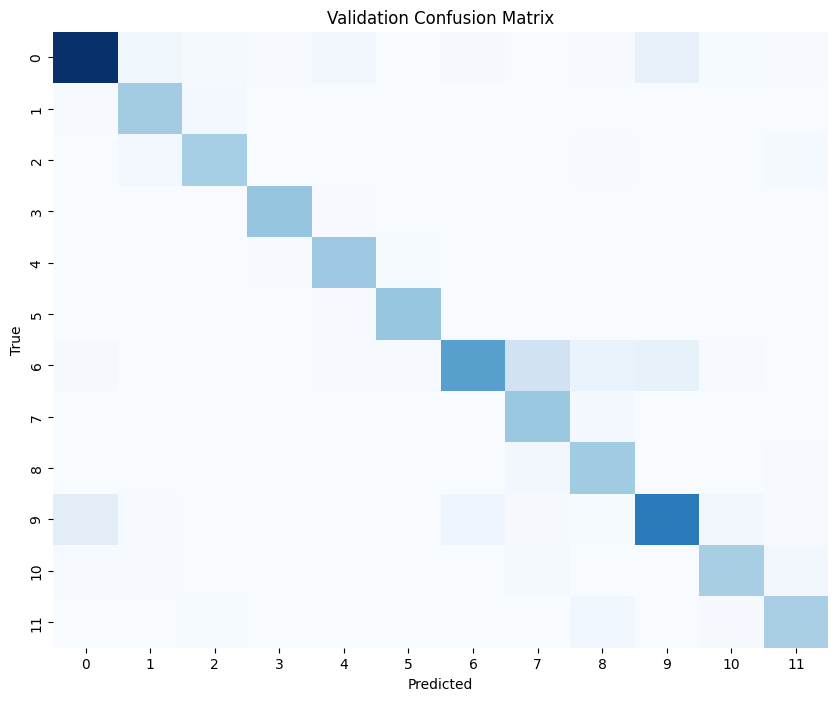

In [34]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

report = classification_report(val_labels, val_preds, target_names=class_names, digits=4)
print(report)
cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, cmap='Blues', cbar=False)
plt.title('Validation Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [35]:
@torch.no_grad()
def predict_one(path: Path):
    img = datasets.folder.default_loader(path)
    x = eval_tfms(img).unsqueeze(0).to(device)
    logits = model(x)
    probs = torch.softmax(logits, dim=1).squeeze(0)
    topk = torch.topk(probs, k=num_classes)
    top_labels = [idx_to_class[i.item()] for i in topk.indices]
    return list(zip(top_labels, topk.values.cpu().tolist()))

# Example
sample_path = "data/RSCD dataset-1million/test_50k/202202081538546-fresh_snow.jpg"
sample_path, predict_one(sample_path)


('data/RSCD dataset-1million/test_50k/202202081538546-fresh_snow.jpg',
 [('fresh_snow', 0.9808152914047241),
  ('ice', 0.01572992466390133),
  ('melted_snow', 0.0033535591792315245),
  ('water_asphalt', 8.611679368186742e-05),
  ('water_mud', 1.2657484148803633e-05),
  ('dry_asphalt', 1.1104524446636788e-06),
  ('dry_gravel', 1.047055661729246e-06),
  ('wet_mud', 1.422536968220811e-07),
  ('wet_asphalt', 1.2291557993648894e-07),
  ('dry_mud', 6.224284732070373e-08),
  ('water_gravel', 2.454994074696515e-08),
  ('wet_gravel', 1.0154735941014792e-09)])